In [41]:
#%pip install numpy opencv-python dlib imutils

In [42]:
#%pip install dlib

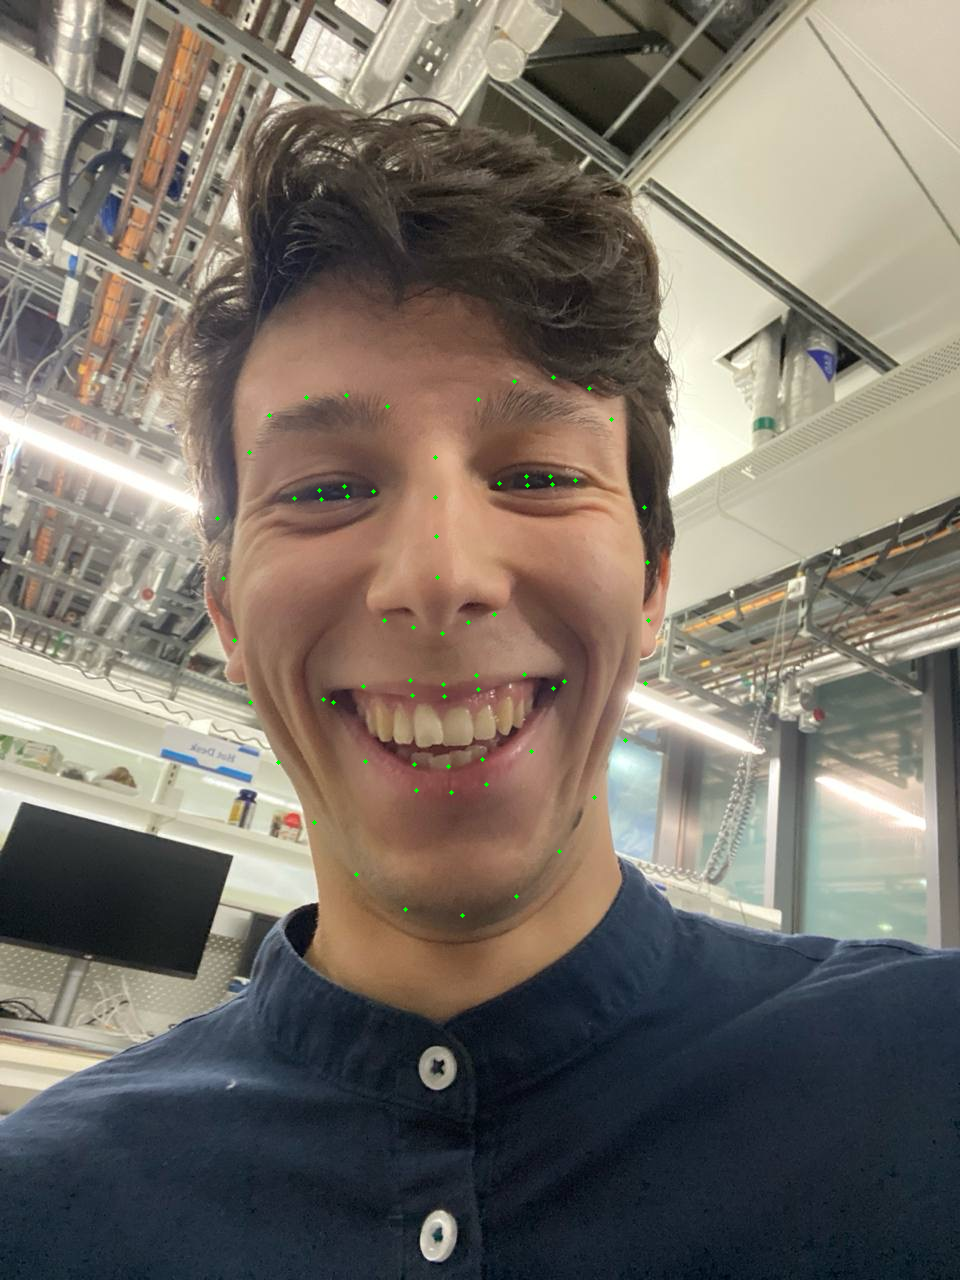

In [47]:
# Import necessary packages
from imutils import face_utils
import numpy as np
import dlib
import cv2
from IPython.display import display, Image
import io

# Initialize dlib's face detector (HOG-based) and facial landmark predictor
p = "detector_architectures/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

# Load the input image from file and convert it to grayscale
image = cv2.imread("Seb_Happy.png")  # Replace with your image path
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
rects = detector(gray, 0)

# Process each face detected
for (i, rect) in enumerate(rects):
    # Determine the facial landmarks and convert to a NumPy array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    #print(shape)

    # Print out the coordinates of the keypoints
    # print("Keypoints for face {}:".format(i + 1))
    # for (x, y) in shape:
    #     print((x, y))


    # Draw facial landmarks on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

# Convert the image to display in Jupyter
def show_image(image):
    _, img_encoded = cv2.imencode('.png', image)
    display(Image(data=img_encoded.tobytes()))

# Display the output image
show_image(image)


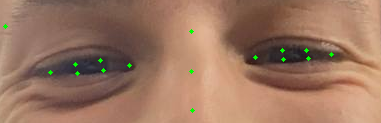

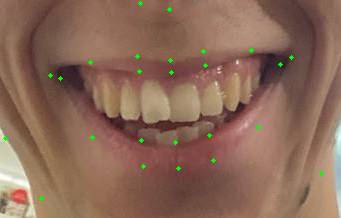

In [48]:
import cv2

# Replace this with the actual keypoints list
keypoints = shape # Replace with your keypoints

def extract_region_of_interest(keypoints, image, region_indices, padding=50):
    # Compute the bounding box for the region of interest
    x_coordinates = [point[0] for point in keypoints[region_indices]]
    y_coordinates = [point[1] for point in keypoints[region_indices]]
    x_min, x_max = max(0, min(x_coordinates) - padding), min(image.shape[1], max(x_coordinates) + padding)
    y_min, y_max = max(0, min(y_coordinates) - padding), min(image.shape[0], max(y_coordinates) + padding)
    
    # Crop the region of interest from the image
    return image[y_min:y_max, x_min:x_max]

# Extract ROIs for eyes and mouth from the image
eye_indices = list(range(36, 48))  # Indices for eye keypoints
mouth_indices = list(range(48, 68))  # Indices for mouth keypoints
eye_roi = extract_region_of_interest(keypoints, image, eye_indices)
mouth_roi = extract_region_of_interest(keypoints, image, mouth_indices)

# Save or display the cropped images
cv2.imwrite('eye_image3.png', eye_roi)
cv2.imwrite('mouth_image3.png', mouth_roi)

# If you want to display the images in a Jupyter notebook:
from IPython.display import display, Image

def show_image_in_notebook(image_path):
    display(Image(filename=image_path))

show_image_in_notebook('eye_image3.png')
show_image_in_notebook('mouth_image3.png')


In [50]:
import cv2
import numpy as np

def extract_region_of_interest(keypoints, image, region_indices, padding=50):
    # Compute the bounding box for the region of interest
    x_coordinates = [point[0] for point in keypoints[region_indices]]
    y_coordinates = [point[1] for point in keypoints[region_indices]]
    x_min, x_max = max(0, min(x_coordinates) - padding), min(image.shape[1], max(x_coordinates) + padding)
    y_min, y_max = max(0, min(y_coordinates) - padding), min(image.shape[0], max(y_coordinates) + padding)
    
    # Crop the region of interest from the image
    return image[y_min:y_max, x_min:x_max]

def match_templates(roi, templates, method=cv2.TM_CCOEFF_NORMED):
    max_vals = []
    roi = roi.astype(np.float32)  # Convert ROI to float32 if it's not already
    for template in templates:
        template = template.astype(np.float32)  # Ensure template is float32
        if len(roi.shape) > 2 and roi.shape[2] == 3:
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)  # Convert ROI to grayscale if it's colored
        if len(template.shape) > 2 and template.shape[2] == 3:
            template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)  # Convert template to grayscale if it's colored
        res = cv2.matchTemplate(roi, template, method)
        _, max_val, _, _ = cv2.minMaxLoc(res)
        max_vals.append(max_val)
    return max_vals

def determine_emotion(eye_roi, mouth_roi, templates):
    # Compare the ROIs with the templates
    eye_matches = match_templates(eye_roi, templates['eye'])
    mouth_matches = match_templates(mouth_roi, templates['mouth'])
    
    # Average match values for eyes and mouth
    average_matches = np.mean([eye_matches, mouth_matches], axis=0)

    # Determine emotion with the highest average match value
    emotions = ['happy', 'sad']
    best_match_index = np.argmax(average_matches)
    
    return emotions[best_match_index]

# Load your image and convert it to grayscale if necessary
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

# Load templates for different emotions (for both eyes and mouth)
# templates = {
#     'eye': {
#         'happy': cv2.imread('Seb_Happy_eye.png', 0),
#         'sad': cv2.imread('Seb_Sad_eye.png', 0),
#     },
#     'mouth': {
#         'happy': cv2.imread('Seb_Happy_mouth.png', 0),
#         'sad': cv2.imread('Seb_Sad_mouth.png', 0),
#     }
# }

templates = {
    'eye': {
        'happy': cv2.imread('eye_image2.png', 0),
        'sad': cv2.imread('Seb_Sad_eye.png', 0),
    },
    'mouth': {
        'happy': cv2.imread('mouth_image2.png', 0),
        'sad': cv2.imread('Seb_Sad_mouth.png', 0),
    }
}

# Flatten the templates dictionary to a list while preserving order
eye_templates = [templates['eye'][emotion] for emotion in ['happy', 'sad']]
mouth_templates = [templates['mouth'][emotion] for emotion in ['happy', 'sad']]

# Define the keypoints for the eyes and mouth regions
# Replace these with the actual keypoints
keypoints = shape

# Extract ROIs for eyes and mouth from the image
eye_indices = list(range(36, 48))  # Indices for eye keypoints
mouth_indices = list(range(48, 68))  # Indices for mouth keypoints
eye_roi = extract_region_of_interest(keypoints, image, eye_indices)
mouth_roi = extract_region_of_interest(keypoints, image, mouth_indices)

# Determine emotion by comparing the extracted ROIs with the templates
emotion = determine_emotion(eye_roi, mouth_roi, {'eye': eye_templates, 'mouth': mouth_templates})
print(f"The determined emotion is: {emotion}")


The determined emotion is: happy


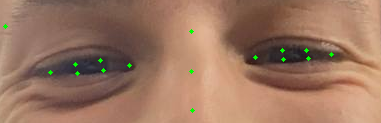

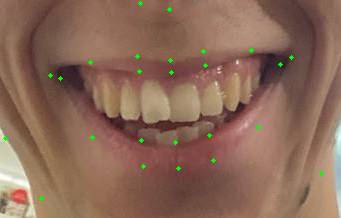

In [49]:
import cv2

# Replace this with the actual keypoints list
keypoints = shape # Replace with your keypoints


# Helper function to get the bounding box of a set of points with padding
def get_bounding_box(points, padding=50):  # Add a padding argument
    x_coordinates, y_coordinates = zip(*points)
    x1, y1, x2, y2 = min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)
    x1 = max(x1 - padding, 0)
    y1 = max(y1 - padding, 0)
    x2 = min(x2 + padding, image.shape[1] - 1)
    y2 = min(y2 + padding, image.shape[0] - 1)
    return (x1, y1, x2, y2)

# Crop the eye region
eye_points = keypoints[36:48]  # Adjust the indices to your keypoints
x1, y1, x2, y2 = get_bounding_box(eye_points)
eye_image = image[y1:y2, x1:x2]

# Crop the mouth region
mouth_points = keypoints[48:68]  # Adjust the indices to your keypoints
x1, y1, x2, y2 = get_bounding_box(mouth_points)
mouth_image = image[y1:y2, x1:x2]

# Save or display the cropped images
cv2.imwrite('eye_image2.png', eye_image)
cv2.imwrite('mouth_image2.png', mouth_image)

# If you want to display the images in a Jupyter notebook:
from IPython.display import display, Image

def show_image_in_notebook(image_path):
    display(Image(filename=image_path))

show_image_in_notebook('eye_image2.png')
show_image_in_notebook('mouth_image2.png')
